## Setup
First we import all the required modules

In [538]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

## Visualization
First we choose the dataset blood-fat.csv and import the data:

In [539]:
bloodfatdata = pd.read_csv("./datasets/blood-fat.csv")

bloodfatdata

,Weight,Age,Blood fat
0,84,46,354
1,73,20,190
2,65,52,405
3,70,30,263
4,76,57,451
5,69,25,302
6,63,28,288
7,72,36,385
8,79,57,402
9,75,44,365


Now we can summarize the data by evaluating the statistics

In [540]:
bloodfatdata.describe()

,Weight,Age,Blood fat
count,25.000000,25.000000,25.00000
mean,68.680000,39.120000,310.72000
std,12.727005,12.248537,77.82915
min,27.000000,20.000000,181.00000
25%,63.000000,30.000000,254.00000
50%,69.000000,37.000000,303.00000
75%,76.000000,50.000000,374.00000
max,89.000000,60.000000,451.00000


Now we can visualize the data by creating a pairplot with pairwise feature scatterplots and feature histograms:

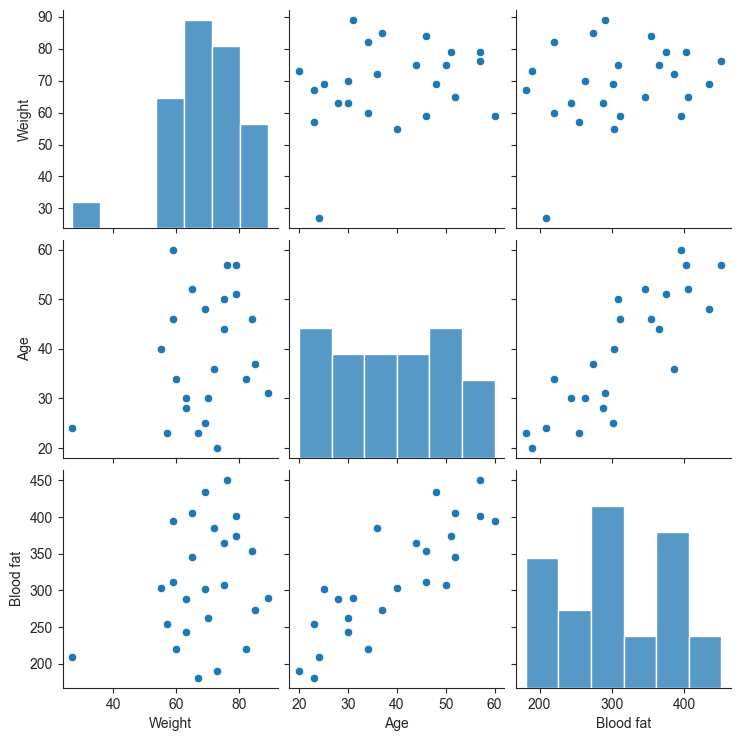

In [541]:
sns.set_style('ticks')
sns.pairplot(data=bloodfatdata)

Now we can also create a heatmap out of the feature correlation matrix

<Axes: >

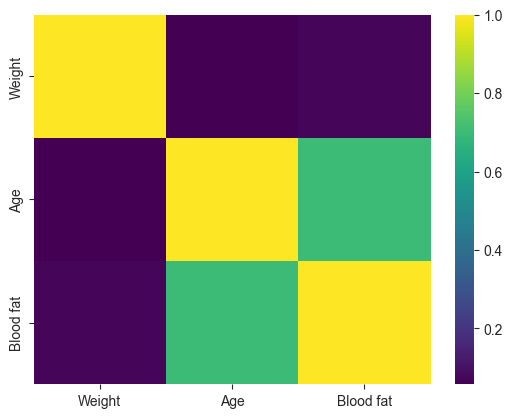

In [542]:
correlation_matrix = bloodfatdata.corr(numeric_only=True)
correlation_matrix
sns.heatmap(correlation_matrix ** 2, cmap='viridis')

## Linear Regression
Now we can perform linear regression on the data. As we can see blood fat and age have the best correlation so we try to perform lienar regression on these 2 features:

In [543]:
bloodfatdata.corr() ** 2

,Weight,Age,Blood fat
Weight,1.000000,0.057606,0.070381
Age,0.057606,1.000000,0.701161
Blood fat,0.070381,0.701161,1.000000


Now we can perform linear regression on the 2 features:

beta vector:  [array([5.32067632]), 102.57514219694275]


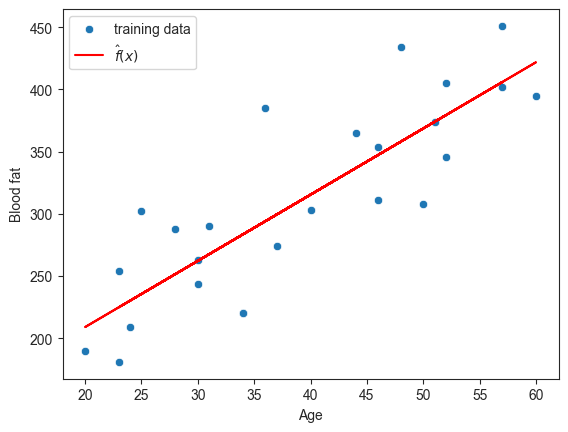

In [544]:
fig, ax = plt.subplots()
sns.scatterplot(data=bloodfatdata, x='Age', y='Blood fat', label='training data')

x = bloodfatdata['Age'].values.reshape(-1, 1) # we have to call reshape because it's a single feature and sklearn expects a matrix
y = bloodfatdata['Blood fat'].values
lr = LinearRegression()
lr.fit(x, y)
print("beta vector: ", [lr.coef_, lr.intercept_])

y_pred = lr.predict(x)
ax.plot(x, y_pred, color='red', label='$\hat{f}(x)$')
ax.legend()

Now we can also evaluate the Prediction qualitiy:

In [545]:
print('Prediction quality: ', r2_score(y, y_pred))

Prediction quality:  0.7011606902368127


## Polynomial Regression
Now we can also try to use Polynomial Regression:

polynomial degree 1: train score: 0.7957491333850097, test score: 0.39176292182523176
polynomial degree 2: train score: 0.7986315318591066, test score: 0.3909420872445314
polynomial degree 3: train score: 0.8334596775334119, test score: 0.20107193940356305
polynomial degree 4: train score: 0.8685943700695046, test score: -0.21965991206050672


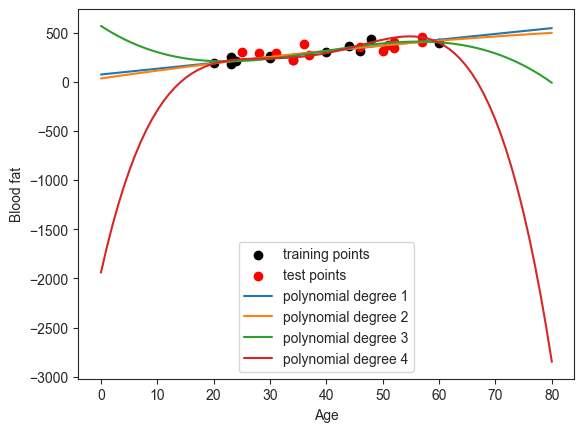

In [546]:
train_split = 0.5

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    bloodfatdata['Age'].values.reshape(-1, 1),
    bloodfatdata['Blood fat'].values,
    train_size=train_split, 
    test_size=1-train_split,
    shuffle=True,
    random_state=6
)

# Sort the training data based on Age
sorted_indices = np.argsort(X_train.flatten())
X_train_sorted = X_train[sorted_indices]
y_train_sorted = y_train[sorted_indices]

fig, ax = plt.subplots()
ax.set_xlabel('Age')
ax.set_ylabel('Blood fat')

# plot Training and test data
ax.scatter(X_train, y_train, label='training points', color='black')
ax.scatter(X_test, y_test, label='test points', color='red')

for degree in range(1, 5):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train_sorted, y_train_sorted)

    # Generate a range of values for plotting
    x_values = np.linspace(0, 80, 80).reshape(-1, 1)

    # Predictions to plot the graph
    y_values_pred = model.predict(x_values)

    ax.plot(x_values, y_values_pred, label=f'polynomial degree {degree}')
    ax.legend()

    y_train_pred = model.predict(X_train_sorted)
    y_test_pred = model.predict(X_test)

    r2_train = r2_score(y_train_sorted, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    print(f'polynomial degree {degree}: train score: {r2_train}, test score: {r2_test}')

plt.show()

### Conclusion
If we increase the degree of the polynomial, the train score gets better, however the testscore gets worse. Using a polynomial degree of 1 provides the best results

## Elastic Net
Now we can also try to use ElasticNet to predict the blood fat, based on Weight and Age:

Optimal regularization parameter:  38.33395101766602


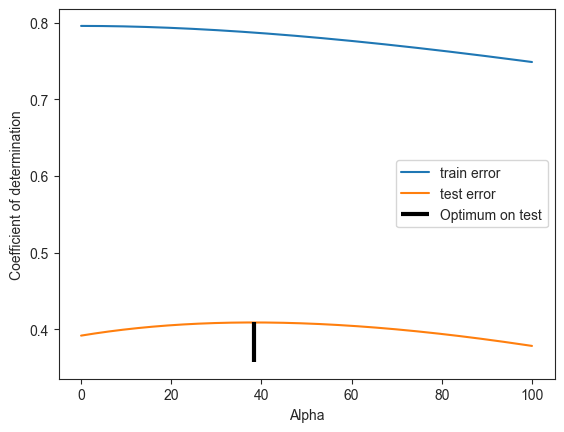

In [547]:
train_split = 0.5

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    bloodfatdata['Age'].values.reshape(-1, 1),
    bloodfatdata['Blood fat'].values,
    train_size=train_split, 
    test_size=1-train_split,
    shuffle=True,
    random_state=6
)

# Initialize the model
alphas = np.logspace(-2, 2, 1000)
enet = ElasticNet(l1_ratio=0.7, max_iter=10000)
train_errors = []
test_errors = []

# Iterate through all alphas to find the best one
for alpha in alphas:
    enet.set_params(alpha=alpha)
    enet.fit(X_train, y_train)
    train_errors.append(enet.score(X_train, y_train))
    test_errors.append(enet.score(X_test, y_test))

best_alpha_index = np.argmax(test_errors)
best_alpha = alphas[best_alpha_index]
enet.set_params(alpha=best_alpha)
print("Optimal regularization parameter: ", best_alpha)

# Now print the test error and the train error
fig, ax = plt.subplots()
ax.set_ylabel('Coefficient of determination')
ax.set_xlabel('Alpha')


ax.plot(alphas, train_errors, label=f'train error')
ax.plot(alphas, test_errors, label=f'test error')
ax.vlines(
    x=best_alpha,
    ymin=ax.get_ylim()[0],
    ymax=np.max(test_errors),
    color="k",
    linewidth=3,
    label="Optimum on test",
)
ax.legend()

plt.show()

Now we can print the results using the best alpha:

polynomial degree 1: train score: 0.7870615787562447, test score: 0.40893285690191483
polynomial degree 2: train score: 0.7636071843660514, test score: 0.38224260401260135
polynomial degree 3: train score: 0.8107705530315682, test score: 0.35998221590511925
polynomial degree 4: train score: 0.8396456154811898, test score: 0.21840210767118517


c:\WORKSPACE\MLDEIL_HW\Assignment_1\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.783e+03, tolerance: 7.445e+00
  model = cd_fast.enet_coordinate_descent(


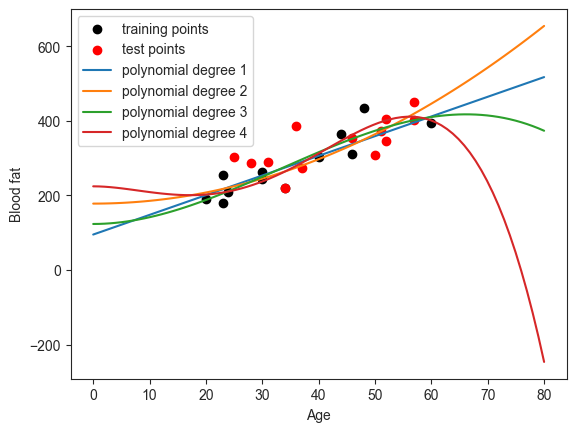

In [548]:
fig, ax = plt.subplots()
ax.set_xlabel('Age')
ax.set_ylabel('Blood fat')

# plot Training and test data
ax.scatter(X_train, y_train, label='training points', color='black')
ax.scatter(X_test, y_test, label='test points', color='red')

for degree in range(1, 5):
    model = make_pipeline(PolynomialFeatures(degree), enet)
    model.fit(X_train_sorted, y_train_sorted)

    # Generate a range of values for plotting
    x_values = np.linspace(0, 80, 80).reshape(-1, 1)

    # Predictions to plot the graph
    y_values_pred = model.predict(x_values)

    ax.plot(x_values, y_values_pred, label=f'polynomial degree {degree}')
    ax.legend()

    y_train_pred = model.predict(X_train_sorted)
    y_test_pred = model.predict(X_test)

    r2_train = r2_score(y_train_sorted, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    print(f'polynomial degree {degree}: train score: {r2_train}, test score: {r2_test}')

plt.show()

We can also use cross validation to find the best parameters for L1 Ratio and Alpha:

In [551]:
train_split = 0.5

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    bloodfatdata['Age'].values.reshape(-1, 1),
    bloodfatdata['Blood fat'].values,
    train_size=train_split, 
    test_size=1-train_split,
    shuffle=True,
    random_state=6
)

parameters = {
    'alpha': np.logspace(-2, 2, 100),
    'l1_ratio': np.linspace(0, 1, 10)
}

enet = ElasticNet(max_iter=10000)

gs = GridSearchCV(estimator=enet, param_grid=parameters, cv=5)
gs.fit(X_train, y_train)

print('Best score: ', gs.best_score_)
print('Best parameters:', gs.best_params_)

c:\WORKSPACE\MLDEIL_HW\Assignment_1\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.515e+03, tolerance: 5.244e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\WORKSPACE\MLDEIL_HW\Assignment_1\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.042e+03, tolerance: 3.732e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the so

Best score:  -1.8857937627668075
Best parameters: {'alpha': 100.0, 'l1_ratio': 0.0}


c:\WORKSPACE\MLDEIL_HW\Assignment_1\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.984e+04, tolerance: 7.445e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


### Conclusion
When using ElasticNet, the R1-Score is basically the same when compared to using LinearRegression, for a polynomial degree of 1. However the test score gets better for increased polynomial degrees. When using GridSearch, I was not able to reproduce the same results.